In [1]:
# changing core directory
import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)
os.chdir('..')

In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf

initialize(config_path='../config/my_configs', version_base=None)

cfg = compose(config_name='attack_run_config.yaml')
# print(OmegaConf.to_yaml(cfg))

/cephfs/projects/danikin/.local/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'attack_run_config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


# Imports

In [3]:
import os

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE

import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader

from src.config import get_attack, get_criterion, get_disc_list, get_model
from src.data import MyDataset, load_data, transform_data
from src.estimation.estimators import AttackEstimator

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


# Initializing

In [4]:
print("Dataset", cfg["dataset"])
X_train, y_train, X_test, y_test = load_data(cfg["dataset"]['name'])
X_train, X_test, y_train, y_test = transform_data(
    X_train, X_test, y_train, y_test, slice_data=cfg["slice"]
)

test_loader = DataLoader(
    MyDataset(X_test, y_test), batch_size=cfg["batch_size"], shuffle=False
)

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

attack_model_path = os.path.join(
    cfg["model_folder"],
    f"model_{cfg['model_id_attack']}_{cfg['dataset']['name']}.pt",
)

attack_model = get_model(
    cfg["attack_model"]["name"],
    cfg["attack_model"]["params"],
    path=attack_model_path,
    device=device,
    train_mode=cfg["attack_model"]["attack_train_mode"],
)

criterion = get_criterion(cfg["criterion_name"], cfg["criterion_params"])

if cfg["use_disc_check"]:
    disc_check_list = get_disc_list(
        model_name=cfg["disc_model_check"]["name"],
        model_params=cfg["disc_model_check"]["params"],
        list_disc_params=cfg["list_check_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=False,
    )
else:
    disc_check_list = None

estimator = AttackEstimator(
    disc_check_list,
    cfg["metric_effect"],
    cfg["metric_hid"],
    batch_size=cfg["estimator_batch_size"],
)

Dataset {'name': 'FreezerRegularTrain', 'num_classes': 2, 'seq_len': 301, 'total_object_count': 3000, 'train': {'object_count': 150, 'max': 5.0221355, 'mean': 9.361460188311934e-11, 'min': -2.2294504, 'std': 0.9983374884114627, 'median': 0.49202215, 'roughness': 0.044626377470920846}, 'test': {'object_count': 2850, 'max': 17.147759, 'mean': -1.961832816797836e-11, 'min': -2.2296427, 'std': 0.9983374885036826, 'median': 0.4907972, 'roughness': 0.04412663137700459}}


In [8]:
from torchsummary import summary 

In [ ]:
alphas = [0]
if "alpha" in cfg["attack"]["attack_params"]:
    alphas = cfg["attack"]["attack_params"]["alpha"]


n_steps_list = np.arange(5, 51, 5)
attacks = list()

for alpha in alphas:
    attack_metrics = pd.DataFrame()
    for eps in cfg["attack"]["attack_params"]["eps"]:

        for n_steps in n_steps_list:
            attack_params = dict(cfg["attack"]["attack_params"])
            attack_params["model"] = attack_model
            attack_params["criterion"] = criterion
            attack_params["estimator"] = estimator
            attack_params["alpha"] = alpha
            attack_params["eps"] = eps
            attack_params["n_steps"] = n_steps

            if "list_reg_model_params" in cfg["attack"]:
                attack_params["disc_models"] = get_disc_list(
                    model_name=cfg["disc_model_reg"]["name"],
                    model_params=cfg["disc_model_reg"]["params"],
                    list_disc_params=cfg["attack"]["list_reg_model_params"],
                    device=device,
                    path=cfg["disc_path"],
                    train_mode=cfg["disc_model_reg"]["attack_train_mode"],
                )

            attacks.append(get_attack(cfg["attack"]["name"], attack_params))

logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging
logging


#### Attack and Discriminator choice

In [ ]:
disc_model = disc_check_list[0]

#### Generate Adversarial data

In [ ]:
X_orig = test_loader.dataset.X
y = test_loader.dataset.y

X_all = X_orig.clone()
X_all_if_adv = torch.zeros(X_orig.shape[0])
y_all = y.clone()

metrics_all = pd.DataFrame()

all_steps = torch.zeros(X_orig.shape[0])

for attack in attacks:
    X_adv = attack.apply_attack(test_loader).squeeze()
    X_all = torch.cat([X_all, X_adv], dim=0)

    X_all_if_adv = torch.cat([X_all_if_adv, torch.ones(X_orig.shape[0])])
    y_all = torch.cat([y_all, y], dim=0)

    steps = torch.tensor([attack.n_steps]*X_orig.shape[0])
    all_steps = torch.cat([all_steps, steps])

    metrics = attack.get_metrics().iloc[-1, :].to_frame().T
    metrics_all = pd.concat([metrics_all, metrics], axis=0)

metrics_all = pd.concat([metrics_all, attack.get_metrics().iloc[0, :].to_frame().T], axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
marker_type = y_all + 2*X_all_if_adv.view([-1, 1])

#### Dimensionality Reduction

In [ ]:
tsne = TSNE(n_components=2, perplexity=100)

X_2d = tsne.fit_transform(X_all)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fbd1a8db280>
Traceback (most recent call last):
  File "/cephfs/soft/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cephfs/soft/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cephfs/soft/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cephfs/soft/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


# Density estimation

In [ ]:
def get_KNN(dist_matrix, n_neigbors=5, neigh_self=False):
    n_neigbors = n_neigbors+1 if neigh_self else n_neigbors # n_neigbors+1, если берётся само значение (расстояние 0) и n соседей

    closest_dist, closest_ind = dist_matrix.topk(n_neigbors, largest=False) 
    
    if not neigh_self:
        closest_dist = closest_dist[:, 1:]
        closest_ind = closest_ind[:, 1:]

    return closest_dist, closest_ind


def distance_weights(neigh_dist, temp=1):
    weights = torch.nn.functional.softmax(-neigh_dist/temp, dim=1) # тепература берётся, чтобы само значение (расстояние 0) не давало слишком большой вес
    
    return weights


def density_val(values, neigh_ind, weights):
    
    density_vector = (values[neigh_ind].squeeze() * weights).sum(1)
    return density_vector

def calculate_density(X, vals, neigh_self=False, temp=1):
    distances = torch.cdist(X, X)

    neigh_dist, neigh_ind = get_KNN(distances, neigh_self=neigh_self)
    neigh_wgts = distance_weights(neigh_dist, temp=temp)
    density = density_val(vals, neigh_ind, neigh_wgts).cpu().detach().numpy()

    return density


In [ ]:
disc_preds = disc_model(X_all.unsqueeze(-1).to(device)).cpu()
class_preds = attack_model(X_all.unsqueeze(-1).to(device)).cpu()

In [ ]:
disc_density = calculate_density(X_all, disc_preds, True, 1)
class_density = calculate_density(X_all, class_preds, True, 1)

In [ ]:
y_pred_ = attack_model(X_orig.unsqueeze(-1).to(device)).cpu().round().detach().numpy()

# Density Plotting

In [ ]:
to_plot = pd.DataFrame()

to_plot[['x', 'y']] = X_2d
to_plot['Class pred'] = class_preds.detach().numpy()
to_plot['Disc pred'] = disc_preds.detach().numpy()
to_plot['Marker'] = marker_type
to_plot['steps'] = all_steps

to_plot['Marker'] = to_plot['Marker'].replace({
    0:'Class 0 orig', 
    1:'Class 1 orig',
    2:'Class 0 adv',
    3:'Class 1 adv'
}) 

In [ ]:
# df_check = to_plot[to_plot['Marker'] < 2]

# accuracy_score(df_check['Class pred'].values.round(), df_check['Marker'].values)

In [ ]:
def get_plot(df, color_col, markers=['^', 's', 'v', 'd'], model_type='Classifier', ax=None):
    plot = sns.scatterplot(
        data=df,
        x="x",
        y="y",
        hue=color_col,
        palette="coolwarm",
        # ax=ax,
        style='Marker',
        markers=markers
    )

    steps = df["steps"].unique()[0]
    model_title = type(attack_model).__name__
    acc_title = metrics_all[metrics_all.step_id==steps]["ACC"][0].round(3)
    plot.set(title=f'{model_type}({model_title}) pred, Acc: {acc_title}, n_steps={steps}')

    return plot


In [ ]:
from matplotlib.animation import FuncAnimation

In [ ]:
# fig, ax = plt.subplots(6, 1, figsize=[10, 40])

# for i, steps in enumerate(to_plot.steps.unique()):
#     get_plot(to_plot[to_plot.steps==steps], 'Class pred', ['^', 's'], ax=ax[i])

# dataset_title = f'Dataset: {cfg["dataset"]}'
# attack_name = f'\nAttack: {type(attack).__name__}'
# params_title = f'\neps={attack.eps}, n_steps = {attack.n_steps}'

# plt.suptitle(dataset_title + attack_name + params_title)

# plt.savefig('density_50steps.jpeg', dpi=400)

In [ ]:
metrics_all

,ACC,ROC,PR,F1,EFF,L1,ACC_ORIG_ADV,PROB_HID,ACC_DISC,F1_DISC,ROC_AUC_DISC,CONC,F_EFF_CONC,step_id
0,0.911111,0.911111,0.857667,0.915789,0.084211,21.031984,0.911111,0.980890,0.963889,0.964578,0.995370,0.004630,0.008777,5.0
0,0.755556,0.755556,0.681212,0.780000,0.220000,41.220306,0.755556,0.999997,0.972222,0.972973,0.999846,0.000154,0.000308,10.0
0,0.561111,0.561111,0.533951,0.582011,0.417989,60.870628,0.561111,1.000000,0.972222,0.972973,1.000000,0.000000,0.000000,15.0
0,0.344444,0.344444,0.444444,0.372340,0.627660,80.193954,0.344444,1.000000,0.972222,0.972973,1.000000,0.000000,0.000000,20.0
0,0.155556,0.155556,0.434556,0.200000,0.800000,99.254608,0.155556,1.000000,0.972222,0.972973,1.000000,0.000000,0.000000,25.0
0,0.083333,0.083333,0.440476,0.153846,0.846154,117.956947,0.083333,1.000000,0.972222,0.972973,1.000000,0.000000,0.000000,30.0
0,0.061111,0.061111,0.452200,0.115183,0.884817,136.334595,0.061111,1.000000,0.972222,0.972973,1.000000,0.000000,0.000000,35.0
0,0.038889,0.038889,0.466724,0.074866,0.925134,154.316574,0.038889,1.000000,0.972222,0.972973,1.000000,0.000000,0.000000,40.0
0,0.022222,0.022222,0.479669,0.043478,0.956522,172.115234,0.022222,1.000000,0.972222,0.972973,1.000000,0.000000,0.000000,45.0
0,0.016667,0.016667,0.484409,0.032787,0.967213,189.735245,0.016667,1.000000,0.972222,0.972973,1.000000,0.000000,0.000000,50.0


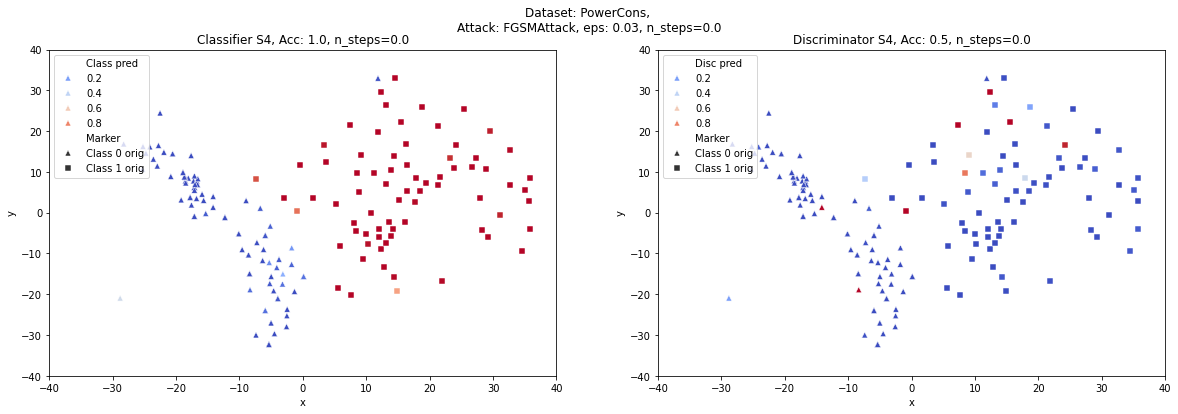

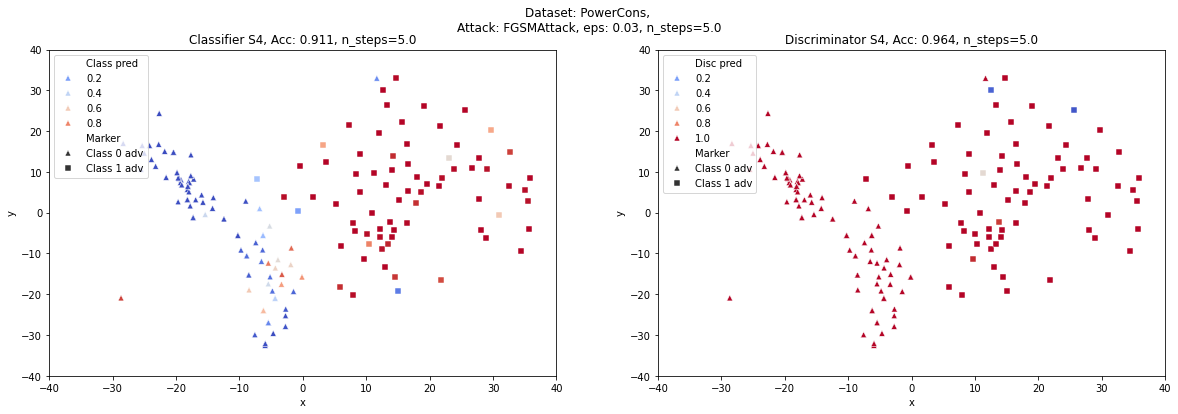

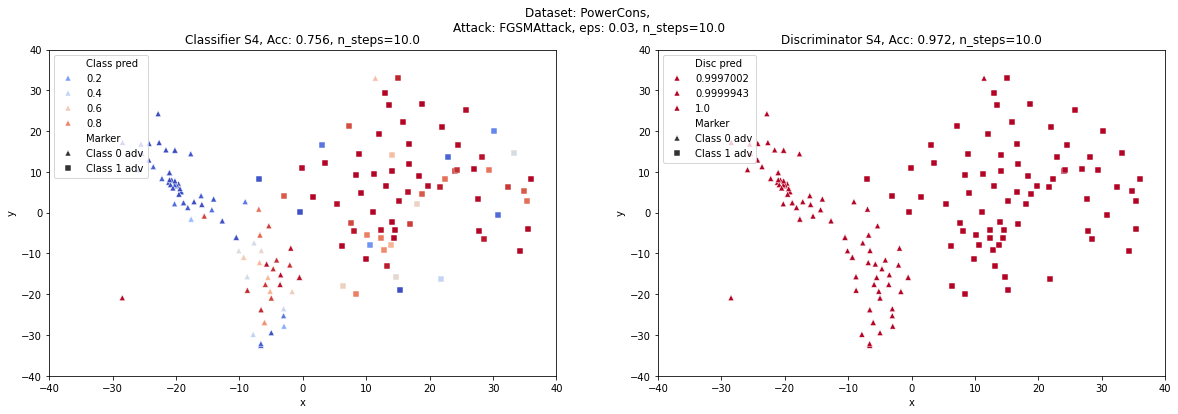

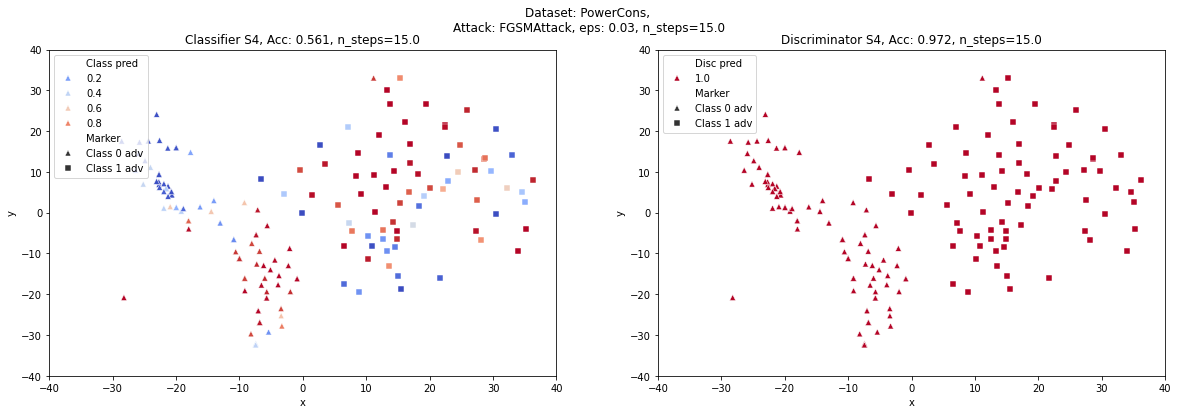

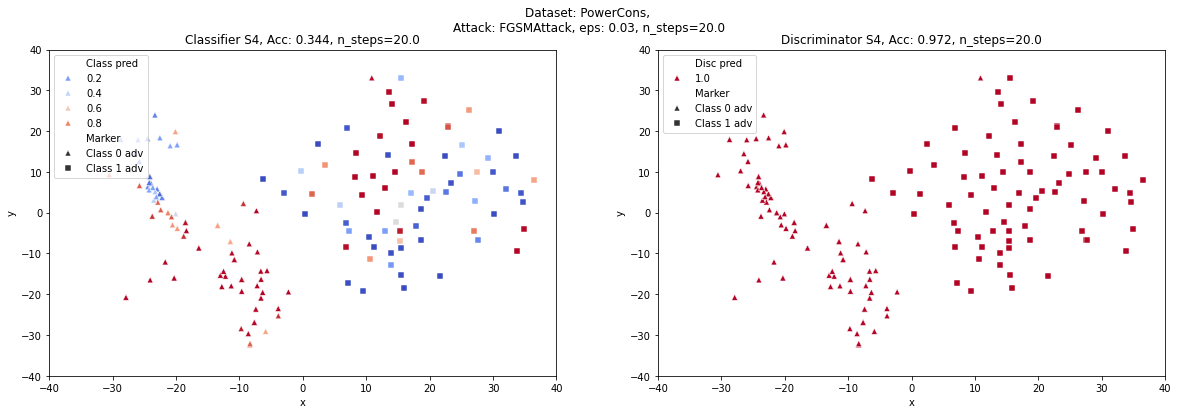

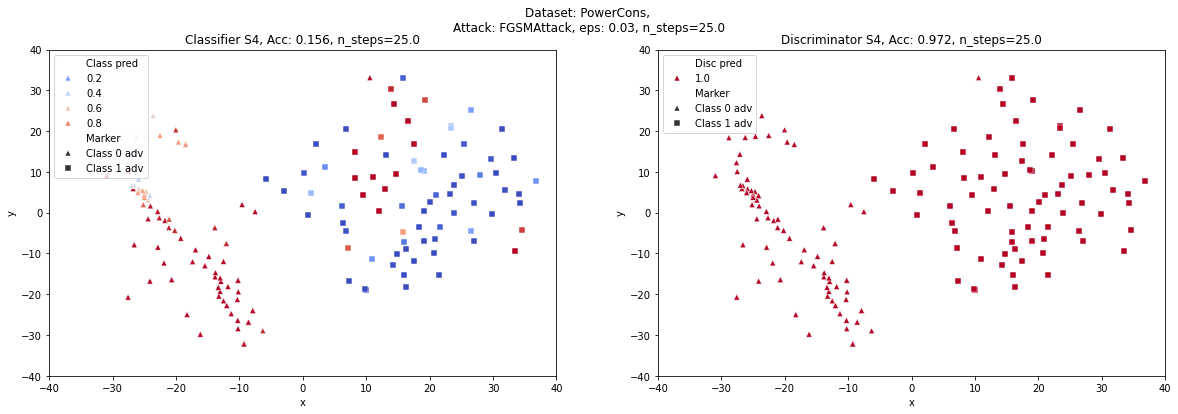

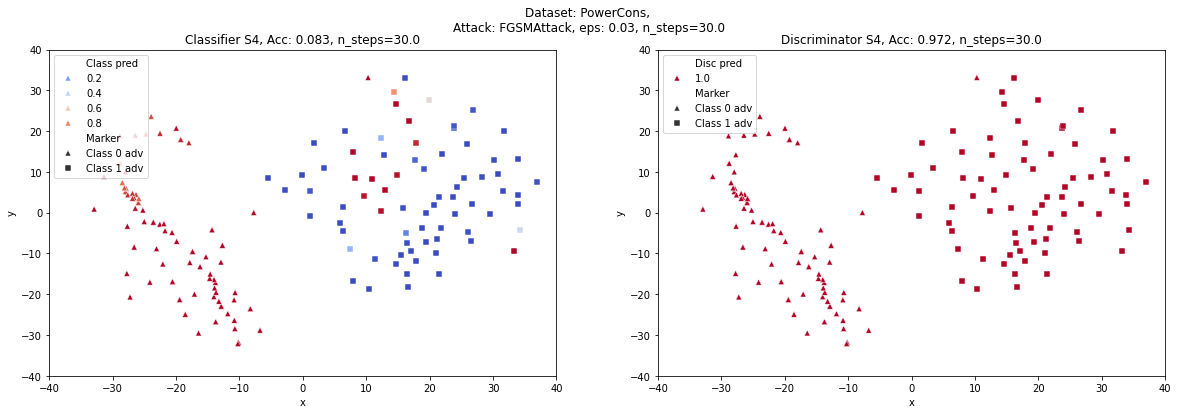

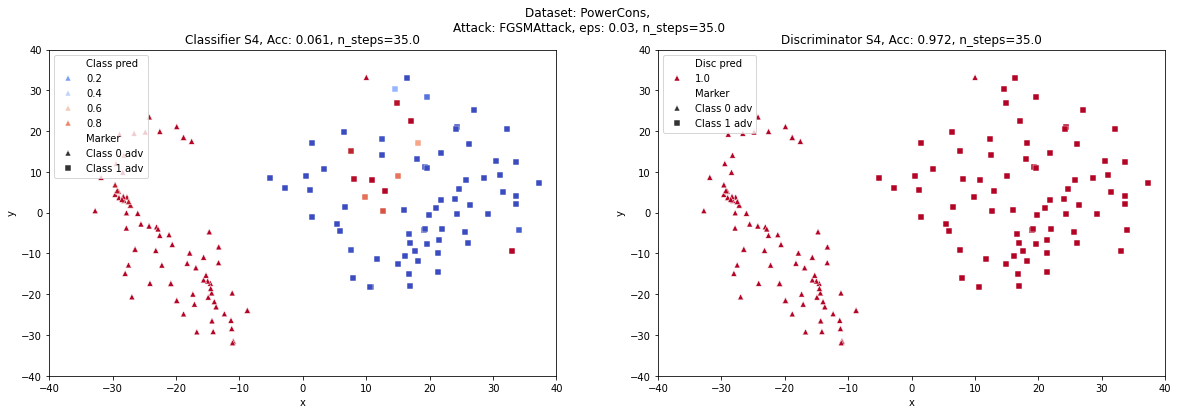

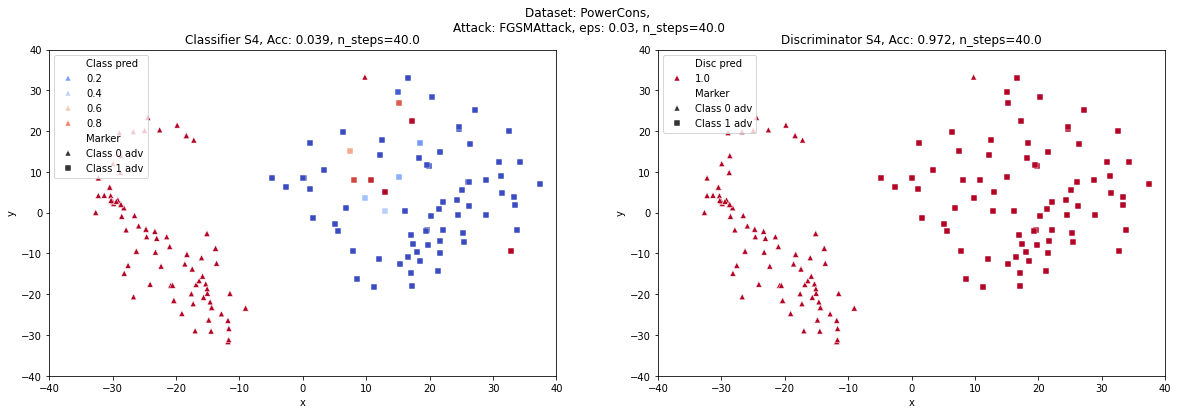

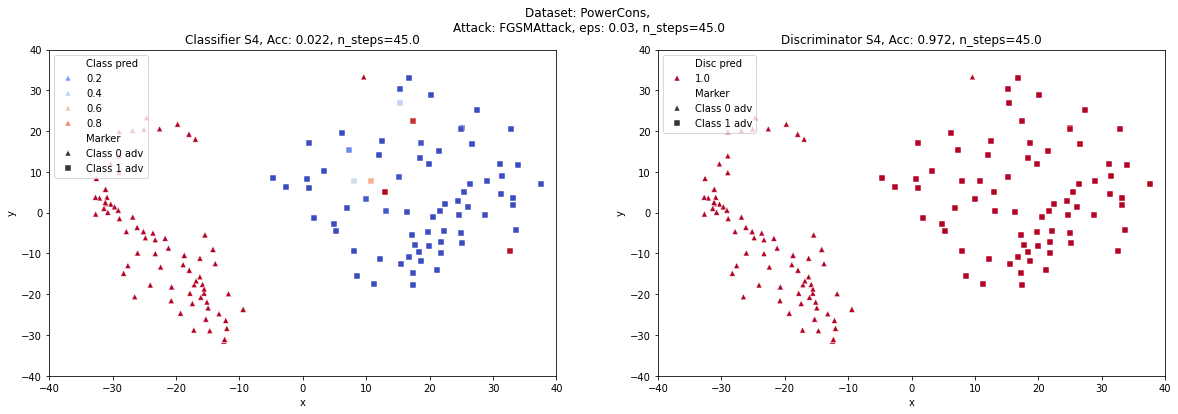

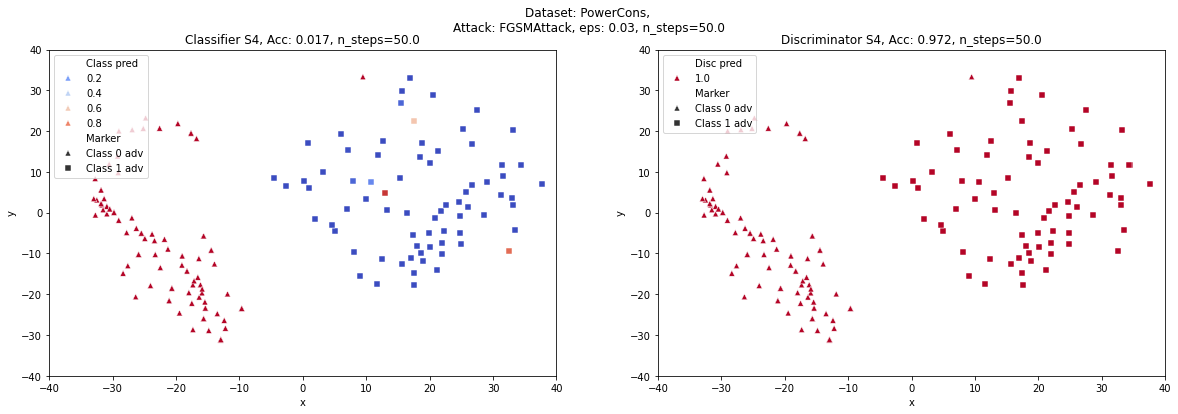

In [ ]:
import matplotlib.pyplot as plt 
import imageio

images = []
folder='results/images'

if not os.path.exists(folder):
    os.mkdir(folder)

my_cmap = sns.color_palette("coolwarm", as_cmap=True)

for i, steps in enumerate(to_plot.steps.unique()):
    df = to_plot[to_plot.steps==steps]
    
    steps = df["steps"].unique()[0]
    dataset_title = f'Dataset: {cfg["dataset"]}'
    
    model_title =  type(attack_model).__name__
    
    class_title = metrics_all[metrics_all.step_id==steps]["ACC"][0].round(3)
    disc_title = metrics_all[metrics_all.step_id==steps]["ACC_DISC"][0].round(3)

    fig, ax = plt.subplots(1, 2, figsize=[20, 6])

    sns.scatterplot(
        data=df,
        x="x",
        y="y",
        hue='Class pred',
        hue_norm=(0, 1),
        style='Marker',
        markers=['^', 's'],
        palette='coolwarm',
        ax = ax[0]
    ).set(title = f'Classifier {model_title}, Acc: {class_title}, n_steps={steps}')

    ax[0].set_xlim([-40, 40])
    ax[0].set_ylim([-40, 40])

    sns.scatterplot(
        data=df,
        x="x",
        y="y",
        hue='Disc pred',
        hue_norm=(0, 1),
        style='Marker',
        markers=['^', 's'],
        palette='coolwarm',
        ax = ax[1]
    ).set(title = f'Discriminator {model_title}, Acc: {disc_title}, n_steps={steps}')

    ax[1].set_xlim([-40, 40])
    ax[1].set_ylim([-40, 40])

    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')
    
    plt.suptitle(f'{dataset_title}, \nAttack: {type(attacks[0]).__name__}, eps: {attacks[0].eps}, n_steps={steps}')

    filename = f'lifeexp_{i}.png'

    plt.savefig(os.path.join(folder,filename), dpi=300)

    images.append(imageio.imread(os.path.join(folder,filename)))

imageio.mimsave(os.path.join(folder,'scatterplot.gif'), images, fps=3)